In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

## Set Seed

In [2]:

def set_seed(seed):
    """Hàm để đặt seed cho các thư viện nhằm đảm bảo kết quả có thể tái tạo."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## DEDEM NNs

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh()
        )
    def forward(self, x):
        return x + self.layers(x)

class DEDEM_Net(nn.Module):
    def __init__(self, input_size=3, hidden_size=30, output_size=1, num_blocks=2):
        super().__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.Tanh()]
        for _ in range(num_blocks):
            layers.append(ResidualBlock(hidden_size))
        layers.append(nn.Linear(hidden_size, output_size))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

## Crack Background 

In [4]:

def crack_embedding_fn(x, y, a):
    relu_squared = torch.clamp(a - x, min=0)**2
    sign_x2 = torch.sign(y)
    return relu_squared * sign_x2

def apply_hard_constraints(u_hat_1, u_hat_2, x, y, domain_y_min, domain_y_max):
    u1 = u_hat_1 * x
    u2 = u_hat_2 * (y - domain_y_min) / (domain_y_max - domain_y_min)
    return u1, u2

## Energy 

In [5]:
def calculate_potential_energy(u1, u2, x, y, params):
    u1_x = torch.autograd.grad(u1.sum(), x, create_graph=True, allow_unused=True)[0]
    u1_y = torch.autograd.grad(u1.sum(), y, create_graph=True, allow_unused=True)[0]
    u2_x = torch.autograd.grad(u2.sum(), x, create_graph=True, allow_unused=True)[0]
    u2_y = torch.autograd.grad(u2.sum(), y, create_graph=True, allow_unused=True)[0]
    
    eps_xx, eps_yy, eps_xy = u1_x, u2_y, 0.5 * (u1_y + u2_x)

    C11 = params['E'] / ((1 + params['nu']) * (1 - 2 * params['nu'])) * (1 - params['nu'])
    C12 = params['E'] / ((1 + params['nu']) * (1 - 2 * params['nu'])) * params['nu']
    C33 = params['E'] / (2 * (1 + params['nu']))

    sigma_xx = C11 * eps_xx + C12 * eps_yy
    sigma_yy = C12 * eps_xx + C11 * eps_yy
    sigma_xy = 2 * C33 * eps_xy

    strain_energy_density = 0.5 * (sigma_xx * eps_xx + sigma_yy * eps_yy + 2 * sigma_xy * eps_xy)
    domain_area = (params['domain_x_max'] - params['domain_x_min']) * (params['domain_y_max'] - params['domain_y_min'])
    total_strain_energy = torch.mean(strain_energy_density) * domain_area

    boundary_mask = (y == params['domain_y_max'])
    u2_boundary = u2[boundary_mask]
    work_traction = torch.mean(u2_boundary * params['sigma_far_field']) * (params['domain_x_max'] - params['domain_x_min'])

    return total_strain_energy - work_traction

## K1 Evaluation 

In [6]:
def calculate_analytical_K1(sigma_pa, a_m, b_m):
    """
    Tính K1 tham chiếu. Kết quả trả về có đơn vị MPa*sqrt(mm).
    """
    sigma_mpa = sigma_pa / 1e6
    a_mm = a_m * 1000
    ratio = a_m / b_m
    
    term1 = sigma_mpa * np.sqrt(np.pi * a_mm)
    term2 = 1 - 0.025 * (ratio)**2 + 0.06 * (ratio)**4
    term3 = np.sqrt(1 / np.cos(np.pi * ratio / 2))
    
    return term1 * term2 * term3

def calculate_K1_from_model(net_u1, net_u2, crack_length_a, params, device):
    """
    Tính K1 từ mô hình đã huấn luyện. Kết quả trả về có đơn vị MPa*sqrt(mm).
    """
    mu = params['E'] / (2 * (1 + params['nu']))
    kappa = 3 - 4 * params['nu']

    x_crack = torch.linspace(0, crack_length_a * 0.99, 100, device=device).unsqueeze(1)
    y_eps = 1e-8
    y_above = torch.full_like(x_crack, y_eps)
    y_below = torch.full_like(x_crack, -y_eps)

    with torch.no_grad():
        embedding_above = crack_embedding_fn(x_crack, y_above, crack_length_a)
        nn_input_above = torch.cat((x_crack, y_above, embedding_above), dim=1)
        u_hat_1_above = net_u1(nn_input_above)
        u_hat_2_above = net_u2(nn_input_above)
        _, u2_above = apply_hard_constraints(u_hat_1_above, u_hat_2_above, x_crack, y_above, params['domain_y_min'], params['domain_y_max'])

        embedding_below = crack_embedding_fn(x_crack, y_below, crack_length_a)
        nn_input_below = torch.cat((x_crack, y_below, embedding_below), dim=1)
        u_hat_1_below = net_u1(nn_input_below)
        u_hat_2_below = net_u2(nn_input_below)
        _, u2_below = apply_hard_constraints(u_hat_1_below, u_hat_2_below, x_crack, y_below, params['domain_y_min'], params['domain_y_max'])

    delta_2 = u2_above - u2_below
    r = crack_length_a - x_crack
    
    K1_apparent_pa_sqrt_m = (mu / (kappa + 1)) * torch.sqrt(2 * torch.pi / r) * delta_2

    filter_mask = (r > 0.2 * crack_length_a) & (r < 0.8 * crack_length_a)
    r_filtered = r[filter_mask]
    K1_apparent_filtered = K1_apparent_pa_sqrt_m[filter_mask]
    
    r_np = r_filtered.cpu().numpy().flatten()
    K1_np = K1_apparent_filtered.cpu().numpy().flatten()

    if len(r_np) < 2: return np.nan
    
    coeffs = np.polyfit(r_np, K1_np, 1)
    K1_pa_sqrt_m = coeffs[1]
    
    # Chuyển đổi từ Pa*sqrt(m) sang MPa*sqrt(mm)
    # 1 Pa*sqrt(m) = 1e-6 MPa * sqrt(1000 mm) = 1e-6 * sqrt(1000) MPa*sqrt(mm)
    K1_final = K1_pa_sqrt_m * (1e-6 * np.sqrt(1000))
    return K1_final

## Grid points check 

In [13]:
# === Hàm visualize lưới điểm hiện tại ===
def visualize_sampling_grid(x_flat, y_flat, title="Lưới điểm đang sử dụng"):
    x_np = x_flat.detach().cpu().numpy().flatten()
    y_np = y_flat.detach().cpu().numpy().flatten()
    plt.figure(figsize=(5, 10))
    plt.scatter(x_np, y_np, s=10)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

In [14]:
SEED_VALUE = 1234
set_seed(SEED_VALUE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

params = {
    'E': 100e9,
    'nu': 0.3,
    'sigma_far_field': 10e6,
    'plate_width_b': 1.0,
    'domain_x_min': 0,
    'domain_x_max': 1.0,
    'domain_y_min': -1.0,
    'domain_y_max': 1.0,
}

Sử dụng thiết bị: cuda


In [15]:
nx, ny = 80, 100
x_p = torch.linspace(params['domain_x_min'], params['domain_x_max'], nx, requires_grad=True, device=device)
y_p = torch.linspace(params['domain_y_min'], params['domain_y_max'], ny, requires_grad=True, device=device)
x_grid, y_grid = torch.meshgrid(x_p, y_p, indexing='ij')
x_flat = x_grid.flatten().unsqueeze(1)
y_flat = y_grid.flatten().unsqueeze(1)

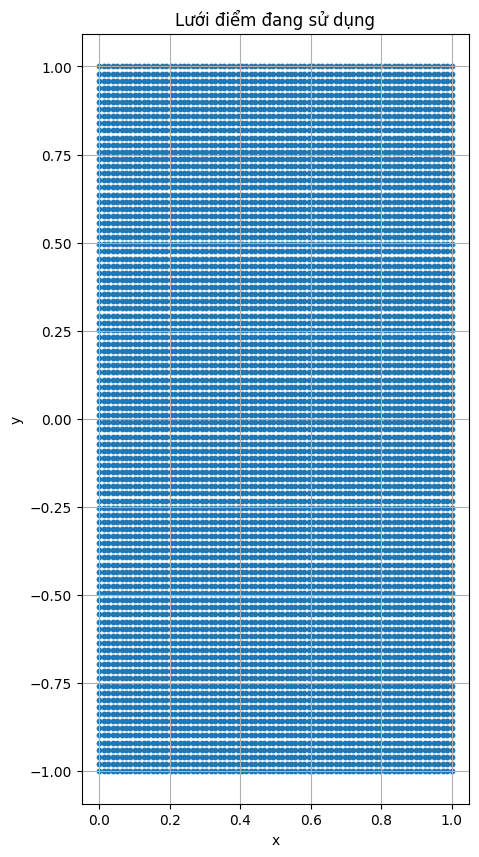

In [16]:
visualize_sampling_grid(x_flat, y_flat, title="Lưới điểm đang sử dụng")

## Grid alter 

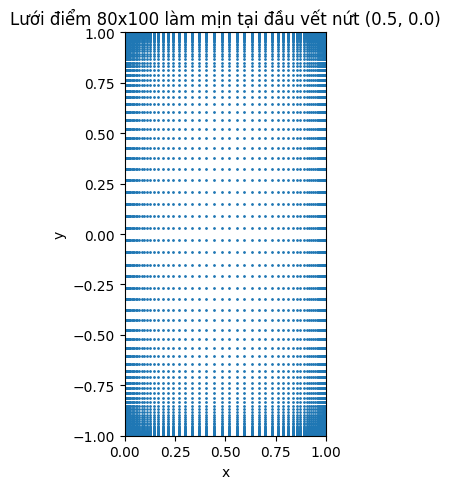

In [27]:
import torch
import matplotlib.pyplot as plt

def create_refined_grid(domain_bounds, grid_size, crack_tip, concentration):
    """
    Tạo một lưới điểm không đồng đều với mật độ cao xung quanh đầu vết nứt.
    
    Args:
        domain_bounds (dict): Giới hạn của miền tính toán {'x_min', 'x_max', 'y_min', 'y_max'}.
        grid_size (dict): Số điểm theo mỗi chiều {'nx', 'ny'}.
        crack_tip (dict): Tọa độ của đầu vết nứt {'x', 'y'}.
        concentration (dict): Hệ số tập trung điểm {'beta_x', 'beta_y'}. 
                              Giá trị càng lớn, điểm càng tập trung.
    
    Returns:
        (torch.Tensor, torch.Tensor): Tọa độ x và y của lưới điểm.
    """
    nx, ny = grid_size['nx'], grid_size['ny']
    x_min, x_max = domain_bounds['x_min'], domain_bounds['x_max']
    y_min, y_max = domain_bounds['y_min'], domain_bounds['y_max']
    tip_x, tip_y = crack_tip['x'], crack_tip['y']
    beta_x, beta_y = concentration['beta_x'], concentration['beta_y']

    # Tạo tọa độ X với mật độ cao xung quanh tip_x
    # 1. Tạo một dãy số đều từ -1 đến 1
    u = torch.linspace(-1, 1, nx)
    # 2. Biến đổi qua hàm tanh để tạo sự co cụm ở giữa
    t = torch.tanh(u * beta_x)
    # 3. Dịch chuyển và co giãn để khớp với miền [x_min, x_max] và tâm co cụm tại tip_x
    x_coords = tip_x + (x_max - x_min) * 0.5 * t / torch.tanh(torch.tensor(beta_x))

    # Tạo tọa độ Y với mật độ cao xung quanh tip_y
    # Quy trình tương tự cho trục y
    v = torch.linspace(-1, 1, ny)
    s = torch.tanh(v * beta_y)
    y_coords = tip_y + (y_max - y_min) * 0.5 * s / torch.tanh(torch.tensor(beta_y))

    # Sắp xếp lại để đảm bảo các điểm luôn tăng dần
    x_coords, _ = torch.sort(x_coords)
    y_coords, _ = torch.sort(y_coords)
    
    # Tạo lưới 2D từ các tọa độ đã tính
    grid_x, grid_y = torch.meshgrid(x_coords, y_coords, indexing='ij')
    
    return grid_x, grid_y

# --- Thiết lập các thông số ---
domain_bounds = {'x_min': 0.0, 'x_max': 1.0, 'y_min': -1.0, 'y_max': 1.0}
grid_size = {'nx': 80, 'ny': 100}
crack_tip = {'x': 0.5, 'y': 0.0}

# Bạn có thể điều chỉnh hệ số này để xem mức độ tập trung thay đổi
concentration = {'beta_x': 3.0, 'beta_y': 3.0}

# Tạo lưới
grid_x, grid_y = create_refined_grid(domain_bounds, grid_size, crack_tip, concentration)

# --- Trực quan hóa lưới điểm ---
plt.figure(figsize=(3.5, 5))
plt.scatter(grid_x.flatten(), grid_y.flatten(), s=1)
plt.title(f"Lưới điểm {grid_size['nx']}x{grid_size['ny']} làm mịn tại đầu vết nứt ({crack_tip['x']}, {crack_tip['y']})")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(domain_bounds['x_min'], domain_bounds['x_max'])
plt.ylim(domain_bounds['y_min'], domain_bounds['y_max'])
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# --- Chuyển đổi sang tensor để tích hợp vào mã huấn luyện ---
# x_flat = grid_x.flatten().unsqueeze(1)
# y_flat = grid_y.flatten().unsqueeze(1)
# x_flat.requires_grad = True
# y_flat.requires_grad = True
# ... (đưa lên device)

## Embedding check

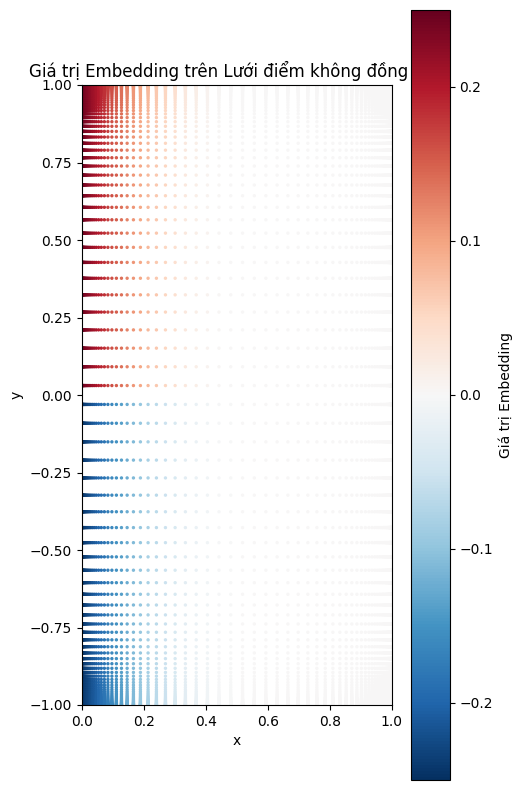

In [29]:
import torch
import matplotlib.pyplot as plt

# Giả định các hàm và biến này đã được định nghĩa từ trước
# ==========================================================
def create_refined_grid(domain_bounds, grid_size, crack_tip, concentration):
    nx, ny = grid_size['nx'], grid_size['ny']
    x_min, x_max = domain_bounds['x_min'], domain_bounds['x_max']
    y_min, y_max = domain_bounds['y_min'], domain_bounds['y_max']
    tip_x, tip_y = crack_tip['x'], crack_tip['y']
    beta_x, beta_y = concentration['beta_x'], concentration['beta_y']
    u = torch.linspace(-1, 1, nx)
    t = torch.tanh(u * beta_x)
    x_coords = tip_x + (x_max - x_min) * 0.5 * t / torch.tanh(torch.tensor(beta_x))
    v = torch.linspace(-1, 1, ny)
    s = torch.tanh(v * beta_y)
    y_coords = tip_y + (y_max - y_min) * 0.5 * s / torch.tanh(torch.tensor(beta_y))
    x_coords, _ = torch.sort(x_coords)
    y_coords, _ = torch.sort(y_coords)
    grid_x, grid_y = torch.meshgrid(x_coords, y_coords, indexing='ij')
    return grid_x, grid_y

def crack_embedding_fn(x, y, a):
    relu_squared = torch.clamp(a - x, min=0)**2
    sign_x2 = torch.sign(y)
    return relu_squared * sign_x2
# ==========================================================


# --- BẮT ĐẦU PHẦN MÃ TÍNH TOÁN VÀ TRỰC QUAN HÓA ---

# 1. Tạo lại lưới điểm không đồng đều (refined grid)
domain_bounds = {'x_min': 0.0, 'x_max': 1.0, 'y_min': -1.0, 'y_max': 1.0}
grid_size = {'nx': 80, 'ny': 100}
crack_tip = {'x': 0.5, 'y': 0.0}
concentration = {'beta_x': 3.0, 'beta_y': 3.0}
refined_grid_x, refined_grid_y = create_refined_grid(domain_bounds, grid_size, crack_tip, concentration)

# 2. Tính giá trị embedding cho mỗi điểm trên refined grid
crack_length_a_vis = 0.5
embedding_values = crack_embedding_fn(refined_grid_x, refined_grid_y, crack_length_a_vis)

# 3. Trực quan hóa bằng scatter plot với màu sắc thay đổi
plt.figure(figsize=(5, 10))

# Sử dụng tham số `c` để gán màu cho mỗi điểm dựa trên giá trị embedding
# s=2 để điểm nhỏ, dễ nhìn
scatter = plt.scatter(
    refined_grid_x.flatten(), 
    refined_grid_y.flatten(), 
    s=2, 
    c=embedding_values.flatten(), 
    cmap='RdBu_r'
)

# Thêm thanh màu để hiển thị thang giá trị
plt.colorbar(scatter, label="Giá trị Embedding")

# Thiết lập các chi tiết cho biểu đồ
plt.title("Giá trị Embedding trên Lưới điểm không đồng đều")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(domain_bounds['x_min'], domain_bounds['x_max'])
plt.ylim(domain_bounds['y_min'], domain_bounds['y_max'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

##  Debug 

In [ ]:
def debug_crack_tip_K1(net_u1, net_u2, crack_length_a, params, device):
    mu = params['E'] / (2 * (1 + params['nu']))
    kappa = 3 - 4 * params['nu']

    x_crack = torch.linspace(0.001, crack_length_a * 0.99, 200, device=device).unsqueeze(1)
    y_eps = 1e-6
    y_above = torch.full_like(x_crack, y_eps)
    y_below = torch.full_like(x_crack, -y_eps)

    with torch.no_grad():
        embedding_above = crack_embedding_fn(x_crack, y_above, crack_length_a)
        nn_input_above = torch.cat((x_crack, y_above, embedding_above), dim=1)
        u_hat_1_above = net_u1(nn_input_above)
        u_hat_2_above = net_u2(nn_input_above)
        _, u2_above = apply_hard_constraints(u_hat_1_above, u_hat_2_above, x_crack, y_above,
                                             params['domain_y_min'], params['domain_y_max'])

        embedding_below = crack_embedding_fn(x_crack, y_below, crack_length_a)
        nn_input_below = torch.cat((x_crack, y_below, embedding_below), dim=1)
        u_hat_1_below = net_u1(nn_input_below)
        u_hat_2_below = net_u2(nn_input_below)
        _, u2_below = apply_hard_constraints(u_hat_1_below, u_hat_2_below, x_crack, y_below,
                                             params['domain_y_min'], params['domain_y_max'])

    delta_u2 = (u2_above - u2_below).cpu().numpy().flatten()
    r = (crack_length_a - x_crack).cpu().numpy().flatten()
    k1_apparent = ((mu / (kappa + 1)) * torch.sqrt(2 * torch.pi / (crack_length_a - x_crack)) * (u2_above - u2_below))
    k1_apparent_np = k1_apparent.cpu().numpy().flatten()

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(r, delta_u2, label=r"$\Delta u_2$")
    axs[0].set_xlabel("r = a - x")
    axs[0].set_ylabel(r"$\Delta u_2$ (m)")
    axs[0].set_title("Hiệu dịch chuyển $u_2$ trên/dưới crack")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(r, k1_apparent_np, label="K1_apparent", color='red')
    axs[1].set_xlabel("r = a - x")
    axs[1].set_ylabel(r"$K_1$ (Pa$\sqrt{m}$)")
    axs[1].set_title("Giá trị $K_1$ ước lượng từ mô hình")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Hàm visualize embedding để kiểm tra trực quan embedding

def visualize_embedding(crack_length_a):
    x = torch.linspace(0, 1.0, 200)
    y = torch.tensor([1e-4, -1e-4])
    for yi in y:
        xi = x.unsqueeze(1)
        yi_repeat = torch.full_like(xi, yi)
        emb = crack_embedding_fn(xi, yi_repeat, crack_length_a)
        plt.plot(x.cpu(), emb.cpu().numpy().flatten(), label=f"y = {yi.item():.0e}")

    plt.title("Embedding function dọc theo x (gần crack)")
    plt.xlabel("x")
    plt.ylabel("Embedding")
    plt.legend()
    plt.grid(True)
    plt.show()

# Hàm in loss từng phần để debug năng lượng

def debug_energy_terms(u1, u2, x, y, params):
    u1_x = torch.autograd.grad(u1.sum(), x, create_graph=True)[0]
    u1_y = torch.autograd.grad(u1.sum(), y, create_graph=True)[0]
    u2_x = torch.autograd.grad(u2.sum(), x, create_graph=True)[0]
    u2_y = torch.autograd.grad(u2.sum(), y, create_graph=True)[0]

    eps_xx, eps_yy, eps_xy = u1_x, u2_y, 0.5 * (u1_y + u2_x)

    C11 = params['E'] / ((1 + params['nu']) * (1 - 2 * params['nu'])) * (1 - params['nu'])
    C12 = params['E'] / ((1 + params['nu']) * (1 - 2 * params['nu'])) * params['nu']
    C33 = params['E'] / (2 * (1 + params['nu']))

    sigma_xx = C11 * eps_xx + C12 * eps_yy
    sigma_yy = C12 * eps_xx + C11 * eps_yy
    sigma_xy = 2 * C33 * eps_xy

    strain_energy_density = 0.5 * (sigma_xx * eps_xx + sigma_yy * eps_yy + 2 * sigma_xy * eps_xy)
    domain_area = (params['domain_x_max'] - params['domain_x_min']) * (params['domain_y_max'] - params['domain_y_min'])
    total_strain_energy = torch.mean(strain_energy_density) * domain_area

    boundary_mask = (y == params['domain_y_max'])
    u2_boundary = u2[boundary_mask]
    work_traction = torch.mean(u2_boundary * params['sigma_far_field']) * (params['domain_x_max'] - params['domain_x_min'])

    print(f"[DEBUG] Strain Energy = {total_strain_energy.item():.4e}, Work = {work_traction.item():.4e}, Total PE = {(total_strain_energy - work_traction).item():.4e}")

# GỌI TỰ ĐỘNG TRONG VÒNG LẶP TRAINING MỖI CRACK A:
# Gắn 3 hàm vào sau mỗi lần huấn luyện

def run_debug_after_training(net_u1, net_u2, crack_a, params, device, x_flat, y_flat, u1, u2):
    print("\n[DEBUG] ===== BẮT ĐẦU PHÂN TÍCH CHI TIẾT =====")
    visualize_embedding(crack_a)
    debug_crack_tip_K1(net_u1, net_u2, crack_a, params, device)
    
    print("[DEBUG] ===== KẾT THÚC PHÂN TÍCH =====\n")

## Train

Sử dụng thiết bị: cuda

BẮT ĐẦU HUẤN LUYỆN CHO TRƯỜNG HỢP a = 0.1 m
  Epoch [1000/15000], Loss: 3.2748e+04
  Epoch [2000/15000], Loss: 9.1680e+03
  Epoch [3000/15000], Loss: 2.6782e+03
  Epoch [4000/15000], Loss: 1.3365e+03
  Epoch [5000/15000], Loss: 3.5313e+02
  Epoch [6000/15000], Loss: -5.4026e+02
  Epoch [7000/15000], Loss: -5.3927e+02
  Epoch [8000/15000], Loss: -7.6421e+02
  Epoch [9000/15000], Loss: -3.6906e+02
  Epoch [10000/15000], Loss: 2.9681e+03
  Epoch [11000/15000], Loss: -1.2080e+03
  Epoch [12000/15000], Loss: -1.0878e+03
  Epoch [13000/15000], Loss: -1.1803e+03
  Epoch [14000/15000], Loss: 4.9668e+02
  Epoch [15000/15000], Loss: -6.4202e+02
-> Huấn luyện hoàn tất. Thời gian: 333.91 giây. Loss cuối cùng: -6.4202e+02
  - K1 (Giải tích): 178.30 MPa*sqrt(mm)
  - K1 (Từ mô hình): 2.97 MPa*sqrt(mm)
  - Sai số: 98.33 %

[DEBUG] ===== BẮT ĐẦU PHÂN TÍCH CHI TIẾT =====


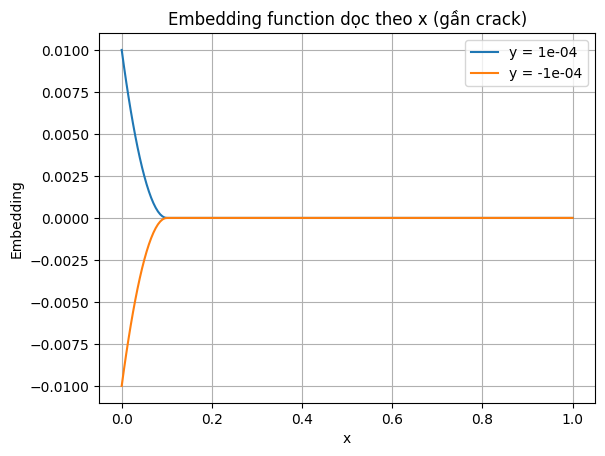

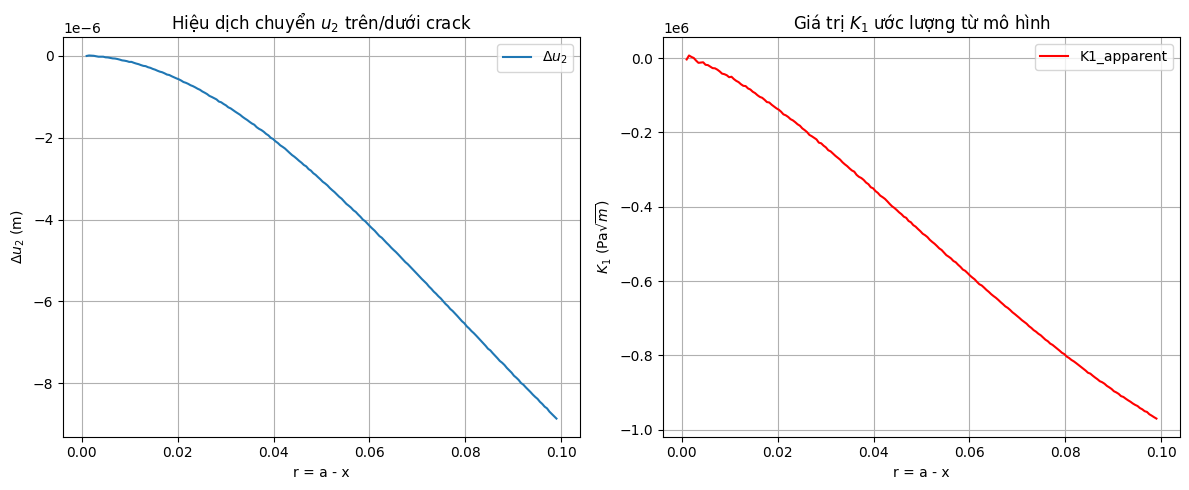

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
# -- Cài đặt và Siêu tham số --
SEED_VALUE = 1234
set_seed(SEED_VALUE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

params = {
    'E': 100e9,
    'nu': 0.3,
    'sigma_far_field': 10e6,
    'plate_width_b': 1.0,
    'domain_x_min': 0,
    'domain_x_max': 1.0,
    'domain_y_min': -1.0,
    'domain_y_max': 1.0,
}

crack_lengths_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results_list = []

# --- Vòng lặp huấn luyện chính ---
for crack_a in crack_lengths_to_test:
    print(f"\n{'='*60}\nBẮT ĐẦU HUẤN LUYỆN CHO TRƯỜNG HỢP a = {crack_a:.1f} m\n{'='*60}")
    
    # 1. Khởi tạo lại mô hình và optimizer cho mỗi lần chạy
    set_seed(SEED_VALUE)
    net_u1 = DEDEM_Net().to(device)
    net_u2 = DEDEM_Net().to(device)

    learning_rate = 0.02
    epochs = 15000  # <<< TĂNG SỐ EPOCHS ĐỂ CÓ KẾT QUẢ TỐT HƠN
    optimizer = torch.optim.Adam(list(net_u1.parameters()) + list(net_u2.parameters()), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)

    # # 2. Tạo lưới điểm
    # nx, ny = 80, 100
    # x_p = torch.linspace(params['domain_x_min'], params['domain_x_max'], nx, requires_grad=True, device=device)
    # y_p = torch.linspace(params['domain_y_min'], params['domain_y_max'], ny, requires_grad=True, device=device)
    # x_grid, y_grid = torch.meshgrid(x_p, y_p, indexing='ij')
    # x_flat = x_grid.flatten().unsqueeze(1)
    # y_flat = y_grid.flatten().unsqueeze(1)
    # --- Thiết lập các thông số ---
    domain_bounds = {'x_min': 0.0, 'x_max': 1.0, 'y_min': -1.0, 'y_max': 1.0}
    grid_size = {'nx': 80, 'ny': 100}
    crack_tip = {'x': 0.5, 'y': 0.0}

    # Bạn có thể điều chỉnh hệ số này để xem mức độ tập trung thay đổi
    concentration = {'beta_x': 3.0, 'beta_y': 3.0}

    # Tạo lưới
    grid_x, grid_y = create_refined_grid(domain_bounds, grid_size, crack_tip, concentration)
    
    start_time = time.time()
    # 3. Chạy vòng lặp huấn luyện
    for epoch in range(epochs):
        net_u1.train()
        net_u2.train()
        optimizer.zero_grad()
        
        embedding = crack_embedding_fn(x_flat, y_flat, crack_a)
        nn_input = torch.cat((x_flat, y_flat, embedding), dim=1)
        
        u_hat_1 = net_u1(nn_input)
        u_hat_2 = net_u2(nn_input)
        
        u1, u2 = apply_hard_constraints(u_hat_1, u_hat_2, x_flat, y_flat, params['domain_y_min'], params['domain_y_max'])
        loss = calculate_potential_energy(u1, u2, x_flat, y_flat, params)

        loss.backward()
        optimizer.step()
        scheduler.step()

        if (epoch + 1) % 1000 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4e}')
    
    end_time = time.time()
    print(f"-> Huấn luyện hoàn tất. Thời gian: {end_time - start_time:.2f} giây. Loss cuối cùng: {loss.item():.4e}")

    # 4. Đánh giá và lưu kết quả
    net_u1.eval()
    net_u2.eval()
    
    k1_from_model = calculate_K1_from_model(net_u1, net_u2, crack_a, params, device)
    k1_analytical = calculate_analytical_K1(params['sigma_far_field'], crack_a, params['plate_width_b'])
    error_percent = abs(k1_from_model - k1_analytical) / abs(k1_analytical) * 100
    
    print(f"  - K1 (Giải tích): {k1_analytical:.2f} MPa*sqrt(mm)")
    print(f"  - K1 (Từ mô hình): {k1_from_model:.2f} MPa*sqrt(mm)")
    print(f"  - Sai số: {error_percent:.2f} %")
    
    results_list.append({
        'Crack Length (a/b)': crack_a / params['plate_width_b'],
        'K1_Analytical (MPa*sqrt(mm))': k1_analytical,
        'K1_From_Model (MPa*sqrt(mm))': k1_from_model,
        'Error (%)': error_percent
    })
    
    # 5. Lưu trọng số mô hình
    torch.save(net_u1.state_dict(), f'net_u1_a_{crack_a:.1f}.pth')
    torch.save(net_u2.state_dict(), f'net_u2_a_{crack_a:.1f}.pth')

# --- Hoàn tất ---
results_df = pd.DataFrame(results_list)
print("\n--- BẢNG KẾT QUẢ TỔNG HỢP ---")
print(results_df)
results_df.to_csv('k1_comparison_results.csv', index=False)